In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import data_loader
import pandas as pd

from models import grids
from utils import data_utils, shape_utils

RUN_FOLDER = "../results/full_run/"
n_samples = 1000

In [2]:
kcm_inputs = data_utils.load_all_inputs(RUN_FOLDER, "kcm/", n_samples)
atb_inputs = data_utils.load_all_inputs(RUN_FOLDER, "atb/", n_samples)

### Traces

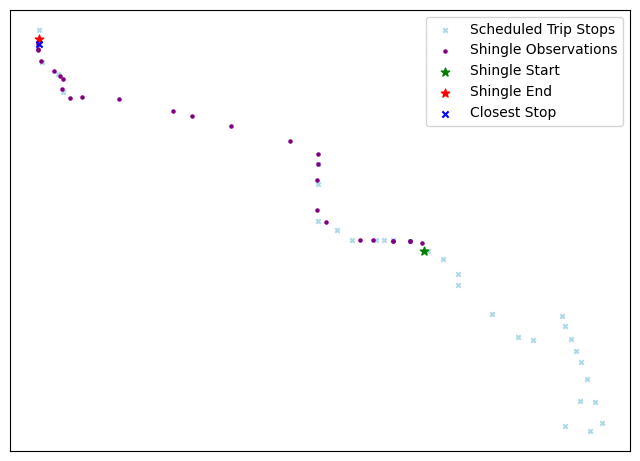

In [5]:
# Look at a single trip
train_traces = kcm_inputs['train_traces']
shingle_data = train_traces[train_traces['shingle_id']==np.unique(train_traces.shingle_id)[0]]
shingle_data.head()
# Plot overview of the shingle
plot_data = shingle_data
fig, axes = plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(8)
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
shape_utils.plot_gtfsrt_trip(axes, plot_data, kcm_inputs['summary_config']['epsg'][0], f".{kcm_inputs['summary_config']['gtfs_folder'][0]}", kcm_inputs['summary_config']['coord_ref_center'][0])
plt.savefig("../plots/kcm_sample_shingle.png", dpi=600, bbox_inches='tight')

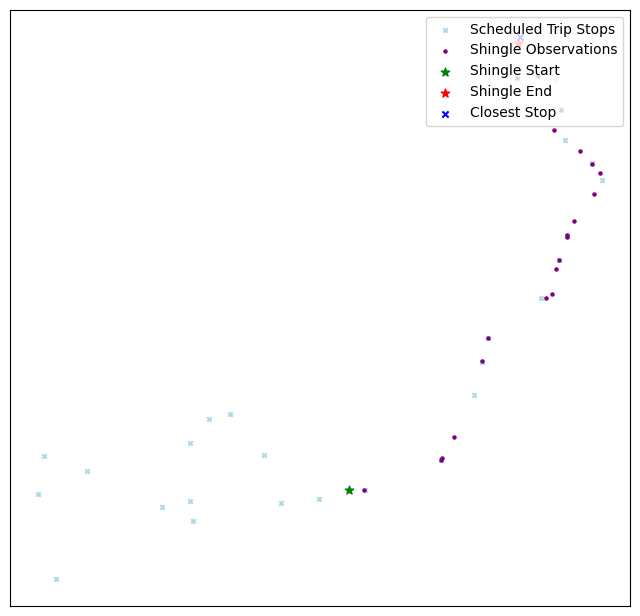

In [6]:
# Look at a single trip
train_traces = atb_inputs['train_traces']
shingle_data = train_traces[train_traces['shingle_id']==np.unique(train_traces.shingle_id)[73]]
shingle_data.head() 
# Plot overview of the shingle
plot_data = shingle_data
fig, axes = plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(8)
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
shape_utils.plot_gtfsrt_trip(axes, plot_data, atb_inputs['summary_config']['epsg'][0], f".{atb_inputs['summary_config']['gtfs_folder'][0]}", atb_inputs['summary_config']['coord_ref_center'][0])
plt.savefig("../plots/atb_sample_shingle.png", dpi=600, bbox_inches='tight')

### Feature Distributions

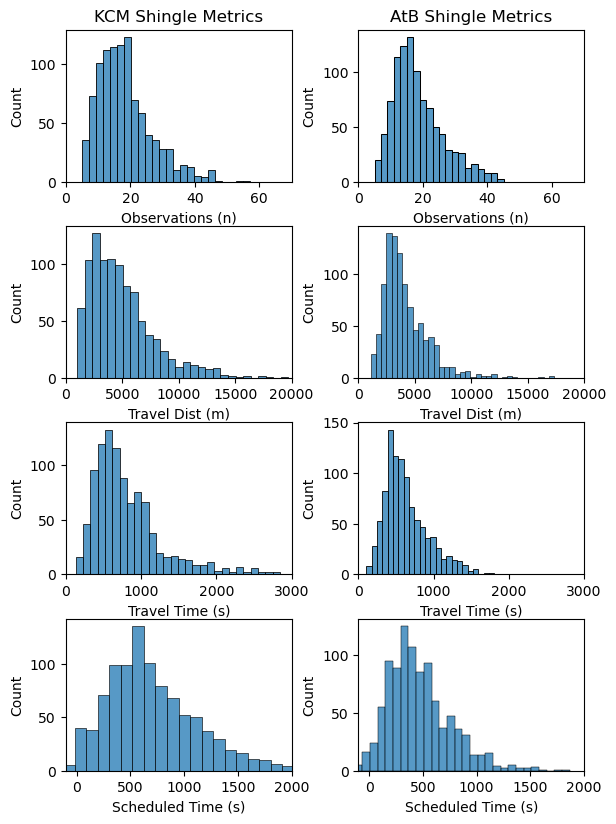

In [8]:
fig, axes = plt.subplots(4,2,figsize=(6,8))
fig.tight_layout()
axes = axes.flatten()

kcm_metric = kcm_inputs['train_traces'].groupby(['shingle_id']).count()['lat']
atb_metric = atb_inputs['train_traces'].groupby(['shingle_id']).count()['lat']
sns.histplot(kcm_metric, ax=axes[0])
axes[0].set_title(f"KCM Shingle Metrics")
axes[0].set_xlabel("Observations (n)")
axes[0].set_xlim(0,70)
sns.histplot(atb_metric, ax=axes[1])
axes[1].set_title(f"AtB Shingle Metrics")
axes[1].set_xlabel("Observations (n)")
axes[1].set_xlim(0,70)

kcm_metric = kcm_inputs['train_traces'].groupby('shingle_id').sum(numeric_only=True)['dist_calc_km']*1000
atb_metric = atb_inputs['train_traces'].groupby('shingle_id').sum(numeric_only=True)['dist_calc_km']*1000
sns.histplot(kcm_metric, ax=axes[2])
axes[2].set_xlabel("Travel Dist (m)")
axes[2].set_xlim(0,20000)
sns.histplot(atb_metric, ax=axes[3])
axes[3].set_xlabel("Travel Dist (m)")
axes[3].set_xlim(0,20000)

kcm_metric = kcm_inputs['train_traces'].groupby('shingle_id').last()['time_cumulative_s']
atb_metric = atb_inputs['train_traces'].groupby('shingle_id').last()['time_cumulative_s']
sns.histplot(kcm_metric, ax=axes[4])
axes[4].set_xlabel("Travel Time (s)")
axes[4].set_xlim(0,3000)
sns.histplot(atb_metric, ax=axes[5])
axes[5].set_xlabel("Travel Time (s)")
axes[5].set_xlim(0,3000)

kcm_metric = kcm_inputs['train_traces'].groupby('shingle_id').last()['scheduled_time_s']
atb_metric = atb_inputs['train_traces'].groupby('shingle_id').last()['scheduled_time_s']
sns.histplot(kcm_metric, ax=axes[6])
axes[6].set_xlabel("Scheduled Time (s)")
axes[6].set_xlim(-100,2000)
sns.histplot(atb_metric, ax=axes[7])
axes[7].set_xlabel("Scheduled Time (s)")
axes[7].set_xlim(-100,2000)
plt.savefig("../plots/shingle_feature_distributions.png", dpi=600, bbox_inches='tight')

### Grid

In [9]:
ngrid_kcm = grids.NGridBetter(kcm_inputs['summary_config']['grid_bounds'][0], 500)
ngrid_kcm.add_grid_content(kcm_inputs['train_traces'], trace_format=True)
ngrid_kcm.build_cell_lookup()
ngrid_atb = grids.NGridBetter(atb_inputs['summary_config']['grid_bounds'][0], 500)
ngrid_atb.add_grid_content(atb_inputs['train_traces'], trace_format=True)
ngrid_atb.build_cell_lookup()

In [10]:
# Examine ngrid
print(f"KCM ngrid points: {ngrid_kcm.points.shape}")
for i in range(ngrid_kcm.points.shape[1]):
    print(f"KCM ngrid feature {i}, mean: {np.mean(ngrid_kcm.points[:,i])}, std: {np.std(ngrid_kcm.points[:,i])}, min: {np.min(ngrid_kcm.points[:,i])}, max: {np.max(ngrid_kcm.points[:,i])}")
print(f"AtB ngrid points: {ngrid_atb.points.shape}")
for i in range(ngrid_atb.points.shape[1]):
    print(f"AtB ngrid feature {i}, mean: {np.mean(ngrid_atb.points[:,i])}, std: {np.std(ngrid_atb.points[:,i])}, min: {np.min(ngrid_atb.points[:,i])}, max: {np.max(ngrid_atb.points[:,i])}")

KCM ngrid points: (18162, 5)
KCM ngrid feature 0, mean: 1677733632.0, std: 724510.25, min: 1676468608.0, max: 1678944384.0
KCM ngrid feature 1, mean: 390115.75, std: 5222.76416015625, min: 373529.625, max: 409616.75
KCM ngrid feature 2, mean: 66835.2578125, std: 10493.818359375, min: 37960.17578125, max: 87572.3125
KCM ngrid feature 3, mean: 6.60674524307251, std: 4.925257205963135, min: 0.002217215718701482, max: 34.83517074584961
KCM ngrid feature 4, mean: 20.546175003051758, std: 101.38495635986328, min: -179.9816131591797, max: 179.9949951171875
AtB ngrid points: (17798, 5)
AtB ngrid feature 0, mean: 1677690112.0, std: 682371.25, min: 1676451328.0, max: 1678918784.0
AtB ngrid feature 1, mean: 570079.5, std: 3036.999755859375, min: 550876.75, max: 577030.3125
AtB ngrid feature 2, mean: 7032388.5, std: 2939.417236328125, min: 7012955.5, max: 7037058.5
AtB ngrid feature 3, mean: 6.230109214782715, std: 3.599640369415283, min: 0.0004046531394124031, max: 34.64669418334961
AtB ngrid fea

In [11]:
# # Look at 1 KCM trip
# train_traces = kcm_inputs['train_traces']
# sample = train_traces[train_traces['shingle_id']==np.unique(train_traces.shingle_id)[0]]
# xbin_idxs, ybin_idxs = ngrid_kcm.digitize_points(sample['x'], sample['y'])
# grid_features = ngrid_kcm.get_grid_features(xbin_idxs, ybin_idxs, sample['locationtime'])
# print(grid_features.shape) # (tsteps, channels, samples, ysteps, xsteps)
# # Select 1st sample for plotting
# grid_features_plot = grid_features[:,:,0,:,:]
# grids.save_grid_anim(grid_features_plot, "grid_n_shingle_kcm.mp4")

In [12]:
# # Look at 1 AtB trip
# train_traces = atb_inputs['train_traces']
# sample = train_traces[train_traces['shingle_id']==np.unique(train_traces.shingle_id)[0]]
# xbin_idxs, ybin_idxs = ngrid_atb.digitize_points(sample['x'], sample['y'])
# grid_features = ngrid_atb.get_grid_features(xbin_idxs, ybin_idxs, sample['locationtime'])
# print(grid_features.shape) # (tsteps, channels, samples, ysteps, xsteps)
# # Select 1st sample for plotting
# grid_features_plot = grid_features[:,:,0,:,:]
# grids.save_grid_anim(grid_features_plot, "grid_n_shingle_atb.mp4")

In [13]:
# # Save plots of full ngrid features
# ngrid_features = ngrid_kcm.get_full_grid(240)
# print(ngrid_features.shape) # (tsteps, channels, latteps, lonsteps)
# ngrid_features = ngrid_features[:500,:,0,:,:] # Look at only first sample, first 16hrs
# grids.save_grid_anim(ngrid_features, "grid_n_kcm.mp4")

In [14]:
# # Save plots of full ngrid features
# ngrid_features = ngrid_atb.get_full_grid(240)
# print(ngrid_features.shape) # (tsteps, channels, latteps, lonsteps)
# ngrid_features = ngrid_features[:500,:,0,:,:] # Look at only first sample, first 16hrs
# grids.save_grid_anim(ngrid_features, "grid_n_atb.mp4")

### Adjacent Trips

In [15]:
# # Run parameters
# shingle_sample_size = 200
# d_buffers = np.linspace(1,1000,20)
# t_buffers = np.linspace(1,60*20,20)
# b_buffer = None
# orthogonal = False

# # Look at speed correlation between adjacent bus trips
# if NETWORK=="kcm":
#     traces = kcm_inputs['test_traces']
# else:
#     traces = atb_inputs['test_traces']
# # Look at only a single hour for the sake of speed (assumes loaded test data comes from single day)
# traces = traces[traces.time<10*60]
# traces = traces[traces.time>=9*60]
# shingle_ids = pd.unique(traces['shingle_id'])
# shingle_id_sample = np.random.choice(shingle_ids, shingle_sample_size, replace=False)

# # Test shingle data against all other data
# shingle_traces = traces[traces['shingle_id'].isin(shingle_id_sample)][['x','y','locationtime','bearing','speed_m_s','shingle_id']]
# shingle_groups = shingle_traces.groupby('shingle_id')
# adj_traces = traces[~traces['shingle_id'].isin(shingle_id_sample)][['x','y','locationtime','bearing','speed_m_s']].values
# # Save results for each shingle, and buffer combination
# targets_res = np.zeros((len(shingle_id_sample), len(d_buffers), len(t_buffers)))
# preds_res = np.zeros((len(shingle_id_sample), len(d_buffers), len(t_buffers)))

# # Parallel: 1min with 200 samples, 20x20 buffers, 1hr data
# # Each item in the results corresponds to a distance buffer; it has n subitems, 1 for each time buffer
# # Within a d-t buffer, there are 4 values; (targets, preds, d_buffer idx, t_buffer idx)
# def parallel_get_metrics(d):
#     dist_buffer = d_buffers[d]
#     results = []
#     for t, t_buffer in enumerate(t_buffers):
#         res = shingle_groups.apply(shape_utils.get_adjacent_metric, adj_traces, dist_buffer, t_buffer, b_buffer=b_buffer, orthogonal=orthogonal)
#         targets = np.array([x[0] for x in res])
#         preds = np.array([x[1] for x in res])
#         results.append((targets, preds, d, t))
#     return results
# res_parallel = Parallel(n_jobs=-2)(delayed(parallel_get_metrics)(x) for x in range(len(d_buffers)))

# # Expand parallel adjacent metric results
# for d_idx in range(len(res_parallel)):
#     for t_idx in range(len(res_parallel[0])):
#         targets = res_parallel[d_idx][t_idx][0]
#         preds = res_parallel[d_idx][t_idx][1]
#         targets_res[:,d_idx,t_idx] = targets
#         preds_res[:,d_idx,t_idx] = preds
# # Get R2 value for each combination of preds and targets and for each d and t buffer
# r_values = np.empty((preds_res.shape[1], preds_res.shape[2]))
# slope_mean = 0.0
# slope_ct = 0
# for d in range(preds_res.shape[1]):
#     for t in range(preds_res.shape[2]):
#         try:
#             non_nan_preds = preds_res[:,d,t][~np.isnan(preds_res[:,d,t])]
#             non_nan_targs = targets_res[:,d,t][~np.isnan(preds_res[:,d,t])]
#             if len(non_nan_preds)>1:
#                 slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(non_nan_preds, non_nan_targs)
#                 r_values[d,t] = r_value**2
#                 slope_mean += slope
#                 slope_ct += 1
#             else:
#                 r_values[d,t] = np.nan
#         except:
#             r_values[d,t] = np.nan
            
# # Plot results for all d/t combos
# print(f"Average slope: {slope_mean / slope_ct}")
# fig, ax = plt.subplots()
# im = ax.imshow(r_values, origin="lower", cmap="plasma")
# fig.suptitle("R2 of Linear Fit to Mean Adjacent Speeds")
# ax.set_title(f"B={b_buffer} deg, Orth={str(orthogonal)}, Net={NETWORK}")
# ax.set_xlabel("Time (s)")
# ax.set_xticks([x for x in range(len(t_buffers))])
# ax.set_xticklabels([str(int(x)) for x in t_buffers], rotation=45)
# ax.set_ylabel("Distance (m)")
# ax.set_yticks([y for y in range(len(d_buffers))])
# ax.set_yticklabels([str(int(y)) for y in d_buffers])
# cbar = fig.colorbar(im, ax=ax)
# plt.draw()
# plt.savefig(f"../plots/R2_adj_{b_buffer}_{str(orthogonal)}_{NETWORK}.png", dpi=600, bbox_inches='tight')
# plt.show()